# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    # skip this if you experience problems with pyglet
    !bash ../xvfb start
    %env DISPLAY=:1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


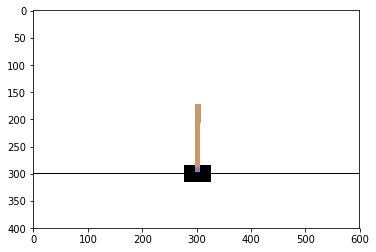

In [4]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [5]:
env.reset()

array([ 0.01310483, -0.00499894,  0.04684104, -0.01034572])

In [98]:
state_dim

(4,)

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [3]:
import torch
import torch.nn as nn

In [7]:
# Build a simple neural network that predicts policy logits. Keep it simple: CartPole isn't worth deep architectures.
agent = nn.Sequential(nn.Linear(state_dim[0],4), nn.ReLU(), nn.Linear(4,n_actions))


# < YOUR CODE HERE: define a neural network that predicts policy logits >

#### Predict function

In [34]:
def predict_proba(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    logits = agent(torch.Tensor(states)) # BS, 2
    probs = nn.Softmax()(logits)
    return probs.data.numpy()


In [35]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis = 1), 1), "probabilities do not sum to 1"

/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [36]:
state = env.reset()
predict_proba([state])[0]

/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


array([0.6175052, 0.3824948], dtype=float32)

### Play the game

We can now use our newly built agent to play the game.

In [37]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    # arrays to record session
    states, actions, rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        # action probabilities array aka pi(a|s)
        action_probas = predict_proba(np.array([s]))[0] 
        
        # sample action (int) with given probabilities. hint: see np.random.choice
        a = np.random.choice([0,1], p=predict_proba(states=state))
        
        new_s, r, done, info = env.step(a)
        
        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [44]:
# test it
states, actions, rewards = generate_session()

/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [45]:
rewards

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

### Computing cumulative rewards

In [50]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    G = []
    
    for i in range(len(rewards), 0, -1):
            if len(G) == 0:
                G_t = rewards[i-1]
            else:
                G_t = rewards[i-1] + gamma * G_t
            G = [G_t] + G
    return G

In [51]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
                   [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [58]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [95]:
# Your code: define optimizers
opt = torch.optim.Adam(agent.parameters())

def train_on_session(states, actions, rewards, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    
    # predict logits, probas and log-probas using an agent. 
    logits = agent(states)
    probas = nn.Softmax()(logits)
    logprobas = torch.log(probas)
    
    assert all(isinstance(v, torch.Tensor) for v in [logits, probas, logprobas]), \
        "please use compute using torch tensors and don't use predict_proba function"
    
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim = 1)
    
#     G = get_cumulative_rewards(rewards=rewards, gamma=gamma)
    # REINFORCE objective function
#     J_hat = <policy objective as in the formula for J_hat. Please use mean, not sum.>
    J_hat = torch.mean(logprobas_for_actions * cumulative_returns.unsqueeze(-1))
    
    #regularize with entropy
    entropy_reg = -torch.sum(probas * logprobas, dim=1).mean()
    
    loss = - J_hat - 0.1 * entropy_reg
    
    # Gradient descent step
    loss.backward()
    opt.step()
    
    # technical: return session rewards to print them later
    return np.sum(rewards)


### The actual training

In [96]:
for i in range(100):
    
    rewards = [train_on_session(*generate_session()) for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 500:
        print ("You Win!") # but you can train even further
        break
        


/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


mean reward:22.870
mean reward:23.130
mean reward:15.130
mean reward:13.090
mean reward:10.580
mean reward:10.260
mean reward:9.580
mean reward:9.300
mean reward:9.340
mean reward:9.390
mean reward:9.290
mean reward:9.510
mean reward:9.400
mean reward:9.430
mean reward:9.390
mean reward:9.470
mean reward:9.290
mean reward:9.420
mean reward:9.280
mean reward:9.310
mean reward:9.280
mean reward:9.420
mean reward:9.350


/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


mean reward:9.380
mean reward:9.480
mean reward:9.320
mean reward:9.500
mean reward:9.240
mean reward:9.320
mean reward:9.380
mean reward:9.420
mean reward:9.210
mean reward:9.370
mean reward:9.370
mean reward:9.380
mean reward:9.370
mean reward:9.270
mean reward:9.470
mean reward:9.390
mean reward:9.340
mean reward:9.370
mean reward:9.460
mean reward:9.410
mean reward:9.360
mean reward:9.440
mean reward:9.310
mean reward:9.390
mean reward:9.310
mean reward:9.380
mean reward:9.320
mean reward:9.390
mean reward:9.400
mean reward:9.290
mean reward:9.360
mean reward:9.330
mean reward:9.410
mean reward:9.340
mean reward:9.310
mean reward:9.330
mean reward:9.430
mean reward:9.350
mean reward:9.370
mean reward:9.320
mean reward:9.440
mean reward:9.290
mean reward:9.330
mean reward:9.370
mean reward:9.430
mean reward:9.340
mean reward:9.260
mean reward:9.390
mean reward:9.400
mean reward:9.420
mean reward:9.270
mean reward:9.380
mean reward:9.380
mean reward:9.300
mean reward:9.310
mean rewar

### Video

In [101]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/daniil/anaconda3/lib/python3.6/site-packages/ipykernel_launche

In [102]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices